In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

# Modelos a comparar
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Para mostrar gráficos
%matplotlib inline

In [6]:
print("📊 --- Cargando y Preparando el Dataset 'Credit Card Fraud' --- 📊")

# Cargar el dataset 'Credit Card Fraud'
data_fraud = fetch_openml(data_id=1597, as_frame=True, parser='auto')
X_fraud = data_fraud.data
y_fraud = pd.Series(pd.factorize(data_fraud.target)[0], index=data_fraud.target.index)
print("Dataset cargado.")

# Guardamos el importe original para usarlo en los pesos
amount_original = X_fraud['Amount'].copy()

# Preprocesamiento: Escalar únicamente la columna 'Amount'
scaler = StandardScaler()
X_fraud['scaled_amount'] = scaler.fit_transform(X_fraud[['Amount']])
X_fraud_proc = X_fraud.drop('Amount', axis=1)

print("Datos preprocesados.")

📊 --- Cargando y Preparando el Dataset 'Credit Card Fraud' --- 📊
Dataset cargado.
Datos preprocesados.


In [7]:
# División de datos (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X_fraud_proc, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)

print(f"Datos divididos: {len(X_train)} para entrenar, {len(X_test)} para probar.")

Datos divididos: 199364 para entrenar, 85443 para probar.


In [8]:
# Creación de los pesos basados en el importe
amount_train = amount_original.loc[y_train.index]

# Usamos np.where: si y_train es 1, usamos amount_train + 1, si no, usamos 1
sample_weights = pd.Series(
    np.where(y_train == 1, amount_train + 1, 1),
    index=y_train.index
)

print("Pesos por muestra (sample_weight) creados correctamente.")

Pesos por muestra (sample_weight) creados correctamente.


In [9]:
# Diccionario de los modelos que vamos a probar
# (probability=True es para poder calcular la curva P-R)
models_to_benchmark = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Diccionario para guardar todos los resultados para la gráfica final
plot_results = {}

In [10]:
print("🚀 --- INICIANDO BENCHMARK DE MODELOS DE VANGUARDIA --- 🚀")

for model_name, model_base in models_to_benchmark.items():
    
    print(f"\n{'='*60}\nProbando modelo: {model_name}\n{'='*60}")
    
    # --- 1. Modelo Convencional ---
    print(f"Entrenando {model_name} (Convencional)...")
    model_conv = model_base.set_params(random_state=42)
    model_conv.fit(X_train, y_train)
    y_pred_conv = model_conv.predict(X_test)
    y_probs_conv = model_conv.predict_proba(X_test)[:, 1]
    
    print("\n--- Resultados (Convencional) ---")
    print(confusion_matrix(y_test, y_pred_conv))
    print(classification_report(y_test, y_pred_conv, target_names=['Normal', 'Fraude'], zero_division=0))

    # --- 2. Modelo Avanzado (sample_weight) ---
    print(f"Entrenando {model_name} (Avanzado con sample_weight)...")
    model_adv = model_base.set_params(random_state=42)
    model_adv.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred_adv = model_adv.predict(X_test)
    y_probs_adv = model_adv.predict_proba(X_test)[:, 1]
    
    print("\n--- Resultados (Avanzado Sensible al Importe) ---")
    print(confusion_matrix(y_test, y_pred_adv))
    print(classification_report(y_test, y_pred_adv, target_names=['Normal', 'Fraude'], zero_division=0))

    # --- 3. Guardar resultados para la gráfica ---
    precision_conv, recall_conv, _ = precision_recall_curve(y_test, y_probs_conv)
    precision_adv, recall_adv, _ = precision_recall_curve(y_test, y_probs_adv)
    
    plot_results[model_name] = {
        'conv': (recall_conv, precision_conv, auc(recall_conv, precision_conv)),
        'adv': (recall_adv, precision_adv, auc(recall_adv, precision_adv))
    }

print("\n✅ --- Benchmark completado --- ✅")

🚀 --- INICIANDO BENCHMARK DE MODELOS DE VANGUARDIA --- 🚀

Probando modelo: Random Forest
Entrenando Random Forest (Convencional)...

--- Resultados (Convencional) ---
[[85290     5]
 [   35   113]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.96      0.76      0.85       148

    accuracy                           1.00     85443
   macro avg       0.98      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Entrenando Random Forest (Avanzado con sample_weight)...

--- Resultados (Avanzado Sensible al Importe) ---
[[85291     4]
 [   41   107]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.96      0.72      0.83       148

    accuracy                           1.00     85443
   macro avg       0.98      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443


Probando

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:02:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados (Convencional) ---
[[85287     8]
 [   40   108]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.93      0.73      0.82       148

    accuracy                           1.00     85443
   macro avg       0.97      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Entrenando XGBoost (Avanzado con sample_weight)...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [12:02:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Resultados (Avanzado Sensible al Importe) ---
[[85287     8]
 [   32   116]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
      Fraude       0.94      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443


Probando modelo: LightGBM
Entrenando LightGBM (Convencional)...
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360519
[LightGBM] [Info] Star

📊 --- GENERANDO GRÁFICA COMPARATIVA P-R FINAL --- 📊


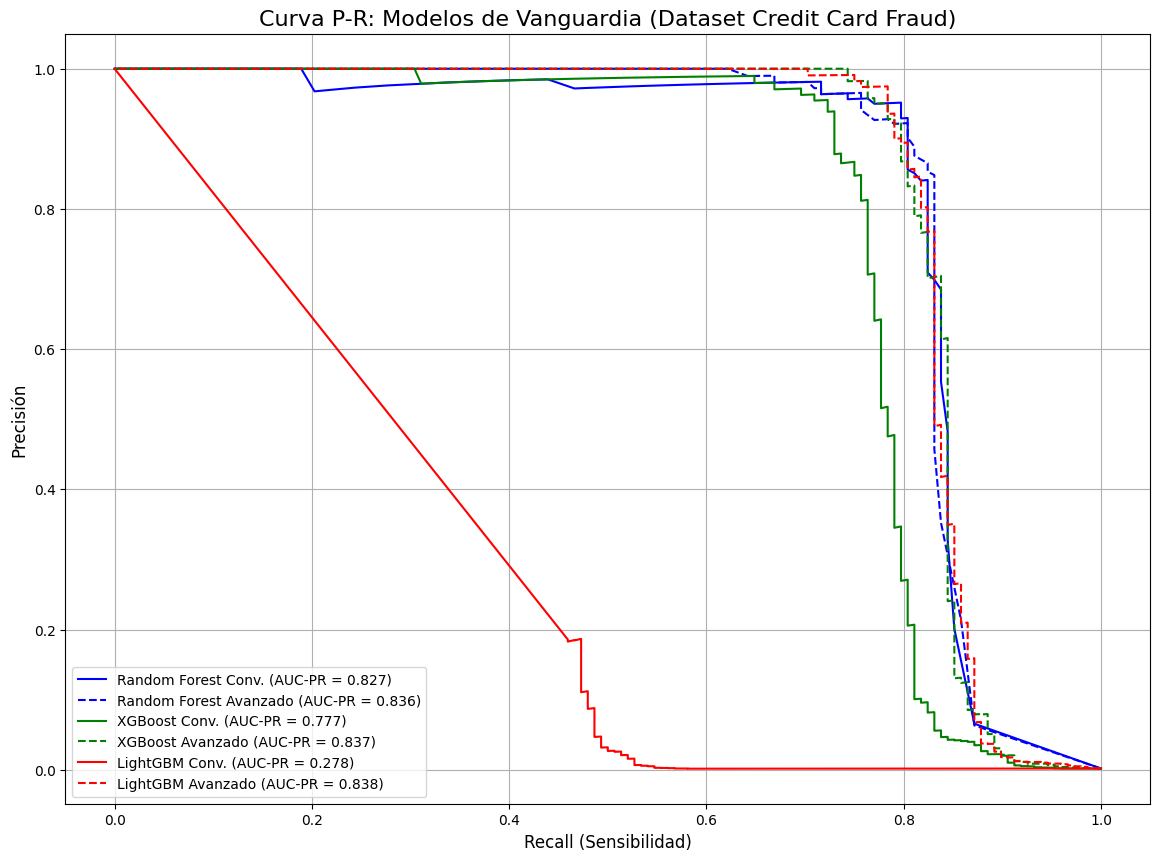

In [11]:
print("📊 --- GENERANDO GRÁFICA COMPARATIVA P-R FINAL --- 📊")

plt.figure(figsize=(14, 10))

# Definir colores para los modelos
colors = {'Random Forest': 'blue', 'XGBoost': 'green', 'LightGBM': 'red'}

for model_name, results in plot_results.items():
    # Modelo Convencional (línea continua)
    recall_conv, precision_conv, auc_pr_conv = results['conv']
    plt.plot(recall_conv, precision_conv, 
             label=f'{model_name} Conv. (AUC-PR = {auc_pr_conv:.3f})', 
             color=colors[model_name], linestyle='-')
    
    # Modelo Avanzado (línea discontinua)
    recall_adv, precision_adv, auc_pr_adv = results['adv']
    plt.plot(recall_adv, precision_adv, 
             label=f'{model_name} Avanzado (AUC-PR = {auc_pr_adv:.3f})', 
             color=colors[model_name], linestyle='--')

plt.title('Curva P-R: Modelos de Vanguardia (Dataset Credit Card Fraud)', fontsize=16)
plt.xlabel('Recall (Sensibilidad)', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()